<style>
/* Style pour améliorer la lisibilité et la présentation */
h1 { color: #2E86C1; text-align: center; font-size: 28px; }
h2 { color: #2874A6; font-size: 24px; }
h3 { color: #1B4F72; font-size: 20px; }
h4 { color: #154360; font-size: 18px; }
p, li { font-size: 16px; }
strong { color: #D35400; }
</style>



# Introduction à l’analyse des données géospatiales appliquée au contexte agricole
# Etude spatio-temporelle de l'indice NDVI et SPI au region Beni-mellal khenifra

---
************************************************************************************************************************************************************
#### Réalisé par : **Adam Daoudi** | Eleve ingenieur en Data Science à l'INSEA 
# Année académique : 2024-2025

---

************************************************************************************************************************************************************
## Introduction
ce projet vise à:
+ **analyser et combiner les indices SPI (précipitations) et NDVI (santé de la végétation) avec des méthodes de machine learning pour détecter, caractériser et prédire les épisodes de sécheresse dans le région de Béni-mellal Khenifra.**
+ **Ce travail s’inscrit dans le cadre de la surveillance de la sécheresse agricole, en combinant l’analyse des déficits pluviométriques (SPI) et la réponse de la végétation (NDVI) à l’échelle mensuelle**

---

## *Problematique* :  **Comment combiner les indices SPI (précipitations) et NDVI (santé de la végétation) avec des méthodes de machine learning pour détecter, caractériser et prédire les épisodes de sécheresse dans le region de Béni-mellal Khénifra ?**

## Méthodologie

### A. Collecte et prétraitement des données géospatiales (ex :MODIS, CHIRPS)
- Téléchargement des données satellites MODIS et précipitations CHIRPS.
- Extraction des variables pertinentes.
- Nettoyage, reprojection et découpage des rasters (zones d’étude proposée :Béni Mellal-Khénifra).


### B. Analyse exploratoire et visualisation cartographique
- Visualisation des cartes NDVI et SPI.
- Etude temporelle (évolution mensuelle/annuelle).
- Corrélations entre indices.


### C. Modélisation statistique ou machine learning
- Développement de modèles de d'etection ou de prédiction de sécheresse.
- Application de modèle machine learning.
- Analyse des résultats et validation.



## A. Téléchargement et preparation des Données NDVI et SPI


### Importation des bibliotheque necessaires 

In [2]:
import os
import urllib.request
import time
from datetime import datetime, timedelta
import gzip
import shutil
import geopandas as gpd 
from osgeo import gdal
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio import open as rio_open
from pymodis import downmodis
import glob
import re
from bs4 import BeautifulSoup
import pandas as pd 
import numpy as np
from scipy.stats import norm, pearsonr
import seaborn as sns 
import matplotlib.pyplot as plt 
import earthaccess 
from pathlib import Path
import logging
import requests

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from xgboost import XGBRegressor, XGBClassifier
from sklearn.svm import SVR
import plotly.express as px 
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

### Chirps dataset (SPI index)

In [3]:

if False:

    base_url = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/africa_monthly/tifs/"
    output_dir = "chirps_data"
    os.makedirs(output_dir, exist_ok=True)


    dates = pd.date_range(start="1981-01", end="2025-05", freq="MS")
    formatted_dates = [date.strftime("%Y.%m") for date in dates]

    for date in formatted_dates:
        filename = f'chirps-v2.0.{date}.tif.gz'
        url = base_url + filename
        filepath = os.path.join(output_dir, filename)

        if os.path.exists(filepath):
            print(f"{filename} déjà présent, on passe.")
            continue

        print(f"Téléchargement de {filename}...")


        max_retries = 3
        for attempt in range(max_retries):
            try:
                urllib.request.urlretrieve(url, filepath)
                print(f"Téléchargé : {filename}")
                break
            except Exception as e:
                print(f"Tentative {attempt + 1} échouée : {e}")
                if attempt < max_retries - 1:
                    print("Nouvelle tentative dans 2 secondes...")
                    time.sleep(2)
                else:
                    print(f"Échec du téléchargement de {filename} après {max_retries} tentatives.")


#### Décompression

In [4]:
if False:
    input_dir = "chirps_data"
    output_dir = "chirps_tif's"
    os.makedirs(output_dir, exist_ok=True)


    for filename in os.listdir(input_dir):
        if filename.endswith(".tif.gz"):
            gz_path = os.path.join(input_dir, filename)
            tif_filename = filename[:-3]  
            tif_path = os.path.join(output_dir, tif_filename)

            
            if os.path.exists(tif_path):
                print(f"{tif_filename} déjà extrait.")
                continue

            #Décompression
            try:
                with gzip.open(gz_path, 'rb') as f_in, open(tif_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
                print(f"Décompressé : {tif_filename}")
            except Exception as e:
                print(f"Erreur avec {filename} : {e}")


#### Découpage

In [5]:
if False:
    input_folder = "chirps_tif's"  # Dossier contenant les fichiers .tif
    output_folder = "chirps_beni_mellal"
    os.makedirs(output_folder, exist_ok=True)

    # Charger le fichier geojson ou shapefile de Beni Mellal-Khénifra
    gdf = gpd.read_file("beni_mellal_khenifra.geojson")  

    # Parcourir les fichiers .tif et les découper
    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith(".tif"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            with rasterio.open(input_path) as src:
                out_image, out_transform = mask(src, gdf.geometry, crop=True)
                out_meta = src.meta.copy()

                # Mettre à jour les métadonnées
                out_meta.update({
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })

                # Enregistrer le fichier découpé
                with rasterio.open(output_path, "w", **out_meta) as dest:
                    dest.write(out_image)

            print(f"Découpé : {filename}")


#### Calcule manuelle de SPI

In [6]:
def calculer_spi(chirps_data, scale=3):
    rolling_precip= chirps_data.rolling(window= scale , min_periods=1).sum()
    mean_precip = rolling_precip.mean()
    std_precip= rolling_precip.std()

    spi=(rolling_precip  - mean_precip) / std_precip
    return spi

#### Calcule des valeurs moyenne de SPI

In [7]:
def extract_mean_values(input_folder, index_type, shapefile_path):
    """Extrait les valeurs moyennes des rasters pour la région"""
    gdf = gpd.read_file(shapefile_path)
    results = []
    
    files = sorted([f for f in os.listdir(input_folder) 
                   if f.endswith((".tif", ".tiff"))])
    
    for file in files:
        file_path = os.path.join(input_folder, file)
        
        try:
            with rasterio.open(file_path) as src:
                if gdf.crs != src.crs:
                    gdf = gdf.to_crs(src.crs)
                
                out_image, _ = mask(src, gdf.geometry, crop=True)
                data = out_image[0]
                
                # Nettoyage des données
                data = np.where((data == src.nodata) | np.isnan(data), np.nan, data)
                
                if index_type.upper() == "NDVI":
                    data = data.astype(float) * 0.0001
                    data = np.where((data < -0.2) | (data > 1.0), np.nan, data)
                elif index_type.upper() == "SPI":
                    data = data.astype(float)
                
                mean_value = np.nanmean(data)
                
                # Extraction de la date
                if index_type.upper() == "NDVI":
                    match = re.search(r'(\d{4}\.\d{2}\.\d{2})', file)
                    if match:
                        date_str = match.group(1)
                        date_obj = pd.to_datetime(date_str, format="%Y.%m.%d")
                else:  # SPI/CHIRPS
                    match = re.search(r'(\d{4}\.\d{2})', file)
                    if match:
                        date_str = match.group(1)
                        date_obj = pd.to_datetime(date_str, format="%Y.%m")
                
                if match:
                    results.append({
                        "date": date_obj, 
                        f"mean_{index_type.lower()}": mean_value
                    })
                    
        except Exception as e:
            print(f"Erreur avec {file}: {e}")
    
    df = pd.DataFrame(results)
    df = df.sort_values("date").reset_index(drop=True)
    return df

In [8]:
shapefile_path = "beni_mellal_khenifra.geojson"

In [9]:
spi_df = extract_mean_values("chirps_beni_mellal", "SPI", shapefile_path="beni_mellal_khenifra.geojson")
ndvi_df = extract_mean_values("ndvi_beni_mellal", "NDVI", shapefile_path="beni_mellal_khenifra.geojson")

In [10]:
spi_df['mean_spi'] = calculer_spi(spi_df['mean_spi'])
spi_df.to_csv('mean_spi_bmk.csv', index=False)
print(f'SPI extrait :{len(spi_df)} observations')

SPI extrait :533 observations


In [11]:
spi_df['year'] = spi_df['date'].dt.year
yearly_spi = spi_df.groupby('year')['mean_spi'].mean().reset_index()

year_min_spi = yearly_spi.loc[yearly_spi['mean_spi'].idxmin(), 'year']
year_max_spi = yearly_spi.loc[yearly_spi['mean_spi'].idxmax(), 'year']
print(f"Année SPI minimum : {year_min_spi}")
print(f"Année SPI maximum : {year_max_spi}")

Année SPI minimum : 1981
Année SPI maximum : 2010


In [ ]:
print(spi_df.head())
print("\n")
print(ndvi_df.head())



        date  mean_ndvi
0 2000-02-18   0.337062
1 2000-03-05   0.313214
2 2000-03-21   0.296915
3 2000-04-06   0.300845
4 2000-04-22   0.290360


### NDVI Dataset (CGMS-Maroc)

In [13]:
output_dir= "C:\\Users\\CE PC\\Desktop\\Drought monitoring\\ndvi_data"
url = 'http://www.cgms-maroc.ma/ndvi/'

In [14]:
date_debut=datetime(2000, 1, 1)
date_actuelle= datetime.now()

In [15]:
os.makedirs(output_dir, exist_ok=True)

### Web Scrapping

In [16]:
import requests

reqs = requests.get(url)
soup= BeautifulSoup(reqs.text, 'html.parser')

In [17]:
if False:
    # Récupération des liens vers les dossiers
    folders = [link['href'] for link in soup.find_all('a') if link['href'].endswith("/")]
    folders

In [18]:
ndvi_links=[]

In [19]:
if False:
    import re

    ndvi_links = []

    pattern = re.compile(r"^ndvi(\d{4}\.\d{2}\.\d{2})\.tiff$", re.IGNORECASE)

    for folder in folders:
        folder_url = url + folder
        reqs_folder = requests.get(folder_url)
        soup_folder = BeautifulSoup(reqs_folder.text, 'html.parser')

        for link in soup_folder.find_all('a'):
            file_name = link['href']
            match = pattern.match(file_name)
            if match:

                ndvi_links.append(folder_url + file_name)

    print(ndvi_links)  # Liste des liens NDVI au bon format

In [20]:
if not ndvi_links:
    print("Aucun fichier ndvi trouvé depuis le 18/02/2000.")
else:
    print(f"{len(ndvi_links)} fichiers NDVI trouvés.")

Aucun fichier ndvi trouvé depuis le 18/02/2000.


In [21]:
if False:

    for link in ndvi_links:
        file_name = link.split('/')[-1]
        print(f"Téléchargement du fichier : {file_name}")

        try:
            r = requests.get(link, stream=True, timeout=30)
            r.raise_for_status()
            with open(os.path.join(output_dir, file_name), 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024 * 1024):
                    if chunk:
                        f.write(chunk)
            print(f"{file_name} téléchargé !\n")
        except Exception as e:
            print(f"Erreur lors du téléchargement de {file_name} : {e}")

    print("Tous les fichiers NDVI ont été téléchargés ")

In [22]:
if False:
    input_folder = "ndvi_data"
    output_folder = "ndvi_beni_mellal"
    os.makedirs(output_folder, exist_ok=True)

    # Charger geojson de la région
    gdf=gdf.to_crs(src.crs)
    gdf = gpd.read_file("beni_mellal_khenifra.geojson") 

    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith(".tiff"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            with rasterio.open(input_path) as src:

                if gdf.crs != src.crs:
                    gdf = gdf.to_crs(src.crs)
                out_image, out_transform = mask(src, gdf.geometry, crop=True)

                out_meta = src.meta.copy()
                out_meta.update({
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })

                with rasterio.open(output_path, "w", **out_meta) as dest:
                    dest.write(out_image)

            print(f"Découpé : {filename}")

### Stockage des données sous format *CSV*

In [23]:
ndvi_df.to_csv("mean_ndvi_bmk.csv", index=False)
print(f"NDVI extrait: {len(ndvi_df)} observations")

NDVI extrait: 1107 observations


In [24]:
#chargement des donnees existantes

ndvi_df = pd.read_csv('mean_ndvi_bmk.csv', parse_dates=['date'])
spi_df = pd.read_csv('mean_spi_bmk.csv', parse_dates=['date'])

In [25]:
# Conversion NDVI mensuel
ndvi_df['month'] = ndvi_df['date'].dt.to_period('M')
monthly_ndvi = ndvi_df.groupby('month')['mean_ndvi'].mean().reset_index()
monthly_ndvi['date'] = monthly_ndvi['month'].dt.to_timestamp()
monthly_ndvi.drop('month', axis=1, inplace=True)

In [26]:
ndvi_df['year'] = ndvi_df['date'].dt.year
yearly_ndvi = ndvi_df.groupby('year')['mean_ndvi'].mean().reset_index()

year_min_ndvi = yearly_ndvi.loc[yearly_ndvi['mean_ndvi'].idxmin(), 'year']
year_max_ndvi = yearly_ndvi.loc[yearly_ndvi['mean_ndvi'].idxmax(), 'year']

print(f"Année NDVI minimum : {year_min_ndvi}")
print(f"Année NDVI maximum : {year_max_ndvi}")

Année NDVI minimum : 2024
Année NDVI maximum : 2018


In [27]:
merged_df = pd.merge(spi_df, monthly_ndvi, on='date', how='inner')
merged_df = merged_df.dropna()
print(merged_df)

print(f"\nDonnées fusionnées: {len(merged_df)} observations")
print(f"Période: {merged_df['date'].min()} à {merged_df['date'].max()}")

          date  mean_spi  mean_ndvi
0   2000-02-01  0.150916   0.337062
1   2000-03-01 -0.242526   0.305065
2   2000-04-01 -0.200493   0.295602
3   2000-05-01  0.099761   0.273207
4   2000-06-01 -0.249848   0.229698
..         ...       ...        ...
299 2025-01-01 -0.082909   0.151669
300 2025-02-01 -0.027971   0.159349
301 2025-03-01  0.195337   0.192912
302 2025-04-01  0.553587   0.210821
303 2025-05-01  0.381375   0.179215

[304 rows x 3 columns]

Données fusionnées: 304 observations
Période: 2000-02-01 00:00:00 à 2025-05-01 00:00:00


## B. Analyse exploratoire et visualisaation cartographique

### Visualisation des cartes NDVI et SPI

In [28]:
df = merged_df.copy()

df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year

annual_means = df.groupby('year')[['mean_ndvi', 'mean_spi']].mean().reset_index()

year_greenest = annual_means.loc[annual_means['mean_ndvi'].idxmax(), 'year']
year_driest = annual_means.loc[annual_means['mean_spi'].idxmin(), 'year']

print(f" Année la plus verte (NDVI max): {year_greenest}")
print(f"Année la plus sèche (SPI min): {year_driest}")


 Année la plus verte (NDVI max): 2018
Année la plus sèche (SPI min): 2024


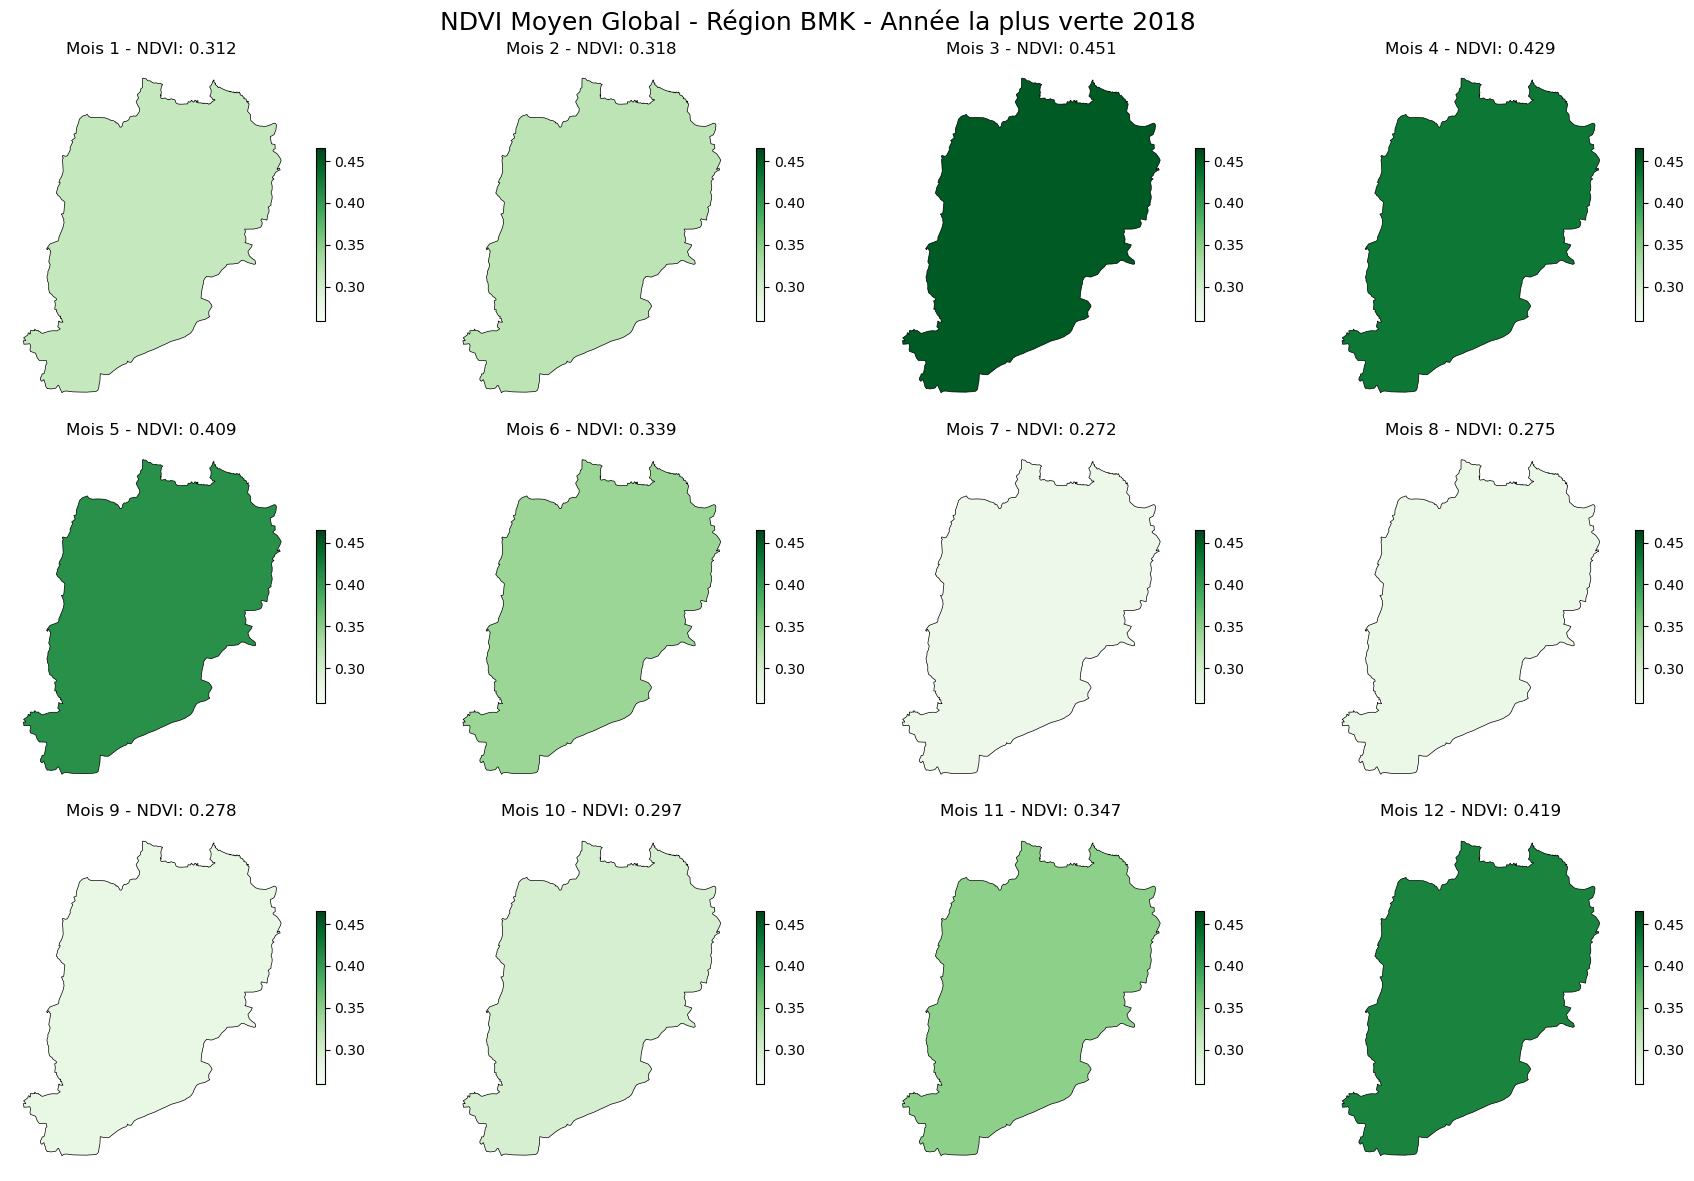

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

region_gdf = gpd.read_file("beni_mellal_khenifra.geojson")
region_union = region_gdf.unary_union  # Fusionner toutes les communes
region_shape = gpd.GeoDataFrame(geometry=[region_union], crs=region_gdf.crs)

ndvi_df = pd.read_csv("mean_ndvi_bmk.csv", parse_dates=["date"])  
ndvi_df["month"] = ndvi_df["date"].dt.month
ndvi_df["year"] = ndvi_df["date"].dt.year


target_year = 2018
ndvi_year_df = ndvi_df[ndvi_df["year"] == target_year]


ndvi_min = ndvi_year_df["mean_ndvi"].min()
ndvi_max = ndvi_year_df["mean_ndvi"].max()


fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for i, month in enumerate(range(1, 13)):
    ax = axes[i]
    month_data = ndvi_year_df[ndvi_year_df["month"] == month]
    
    if not month_data.empty:
        value = month_data.iloc[0]["mean_ndvi"]
        region_shape["ndvi"] = [value]
        region_shape.plot(
            column="ndvi",
            cmap="Greens",  
            linewidth=0.5,
            edgecolor="black",
            legend=True,
            ax=ax,
            vmin=ndvi_min,
            vmax=ndvi_max,
            legend_kwds={'shrink': 0.5}
        )
        ax.set_title(f"Mois {month} - NDVI: {value:.3f}")
    else:
        region_shape["ndvi"] = [None]
        region_shape.plot(color="lightgrey", ax=ax)
        ax.set_title(f"Mois {month} - Données manquantes")

    ax.axis("off")

plt.suptitle(f"NDVI Moyen Global - Région BMK - Année la plus verte {target_year}", fontsize=18)
plt.tight_layout()
plt.show()


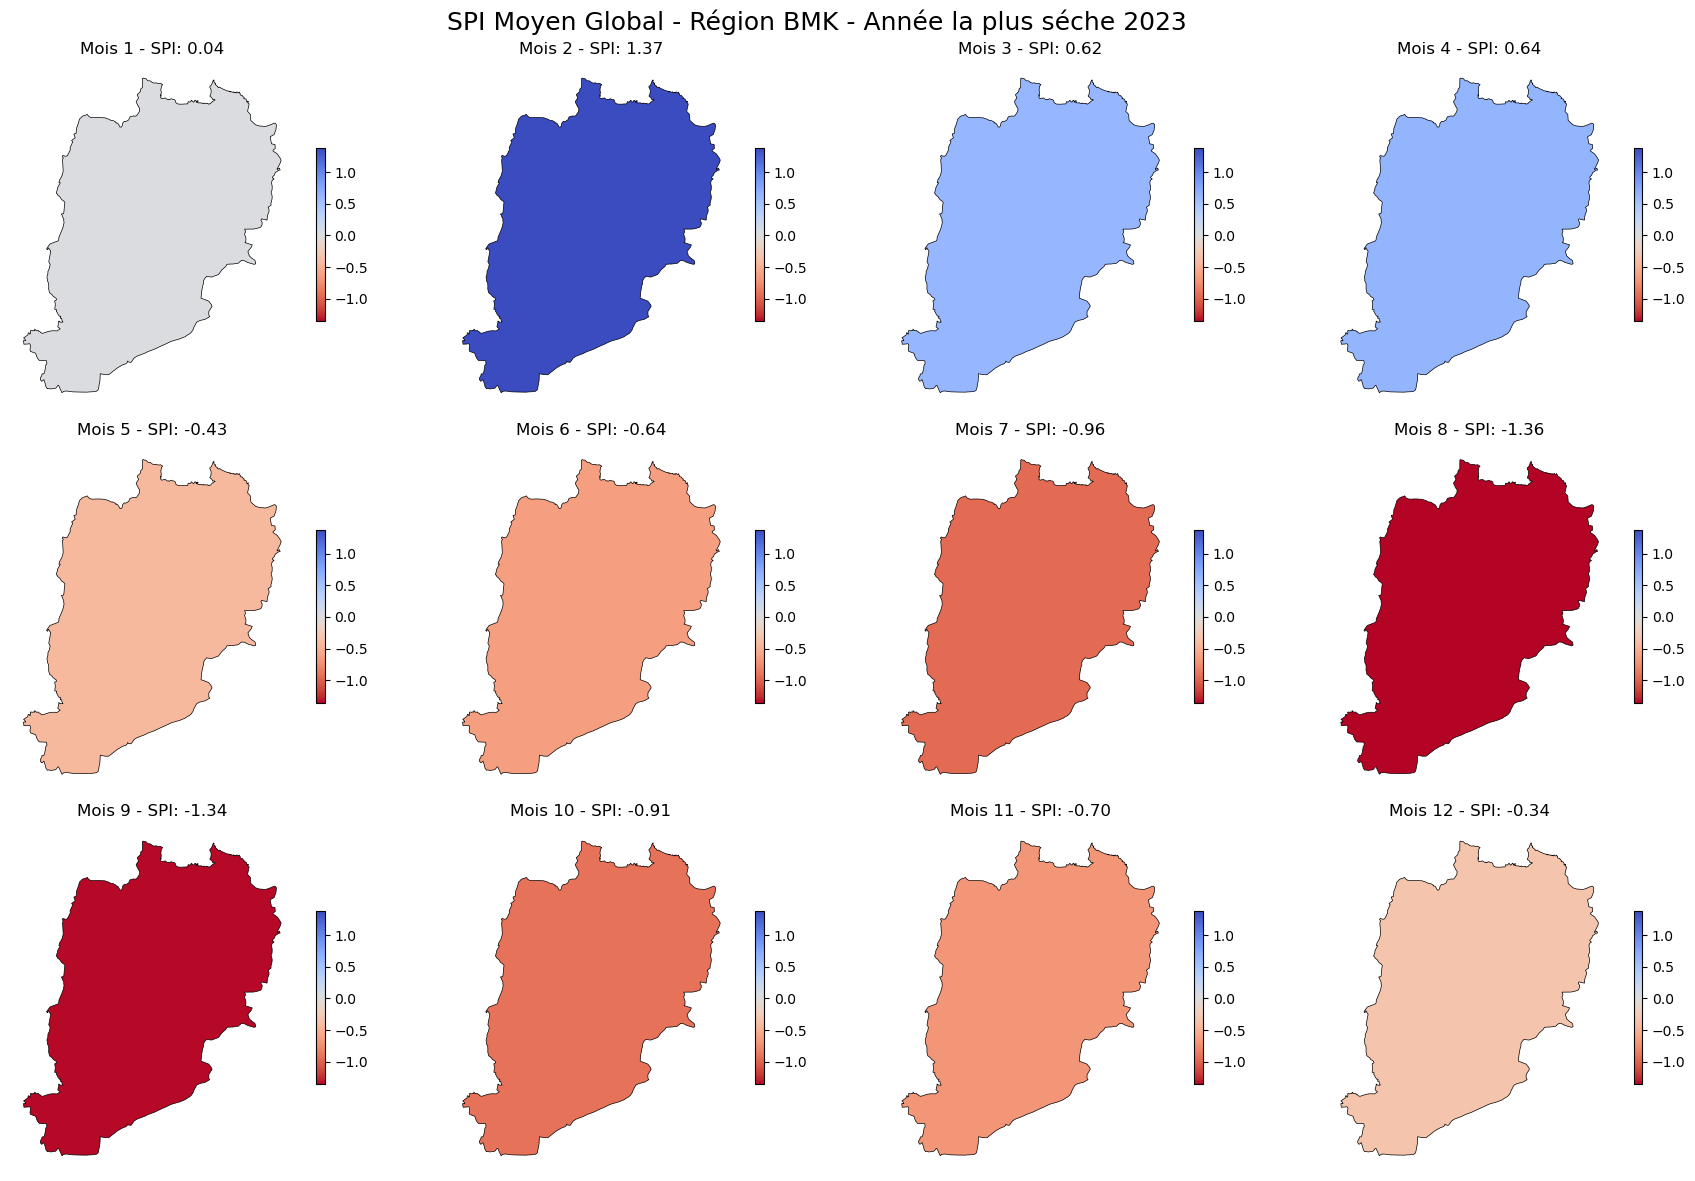

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

region_gdf = gpd.read_file("beni_mellal_khenifra.geojson")

region_union = region_gdf.unary_union
region_shape = gpd.GeoDataFrame(geometry=[region_union], crs=region_gdf.crs)

spi_df = pd.read_csv("mean_spi_bmk.csv", parse_dates=["date"])
spi_df["month"] = spi_df["date"].dt.month
spi_df["year"] = spi_df["date"].dt.year

target_year = 2023 
spi_year_df = spi_df[spi_df["year"] == target_year]

spi_min = spi_year_df["mean_spi"].min()
spi_max = spi_year_df["mean_spi"].max()

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for i, month in enumerate(range(1, 13)):
    ax = axes[i]
    month_data = spi_year_df[spi_year_df["month"] == month]
    
    if not month_data.empty:
        value = month_data.iloc[0]["mean_spi"]
        region_shape["spi"] = [value]
        region_shape.plot(
            column="spi",
            cmap="coolwarm_r",     
            linewidth=0.5,
            edgecolor="black",
            legend=True,
            ax=ax,
            vmin=spi_min,        
            vmax=spi_max,        
            legend_kwds={'shrink': 0.5}
        )
        ax.set_title(f"Mois {month} - SPI: {value:.2f}")
    else:
        region_shape["spi"] = [None]
        region_shape.plot(color="lightgrey", ax=ax)
        ax.set_title(f"Mois {month} - Données manquantes")

    ax.axis("off")

plt.suptitle(f"SPI Moyen Global - Région BMK - Année la plus séche {target_year}", fontsize=18)
plt.tight_layout()
plt.show()


### Etude temporelle 

In [31]:
def create_time_series_plot(df, columns, title):
    
    fig, axes = plt.subplots(len(columns), 1, figsize=(15, 6*len(columns)))
    if len(columns) == 1:
        axes = [axes]
    
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    
    for i, col in enumerate(columns):
        axes[i].plot(df['date'], df[col], color=colors[i], linewidth=2, label=col)
        axes[i].set_title(f'{title} - {col.upper()}', fontsize=14)
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(col.upper())
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()


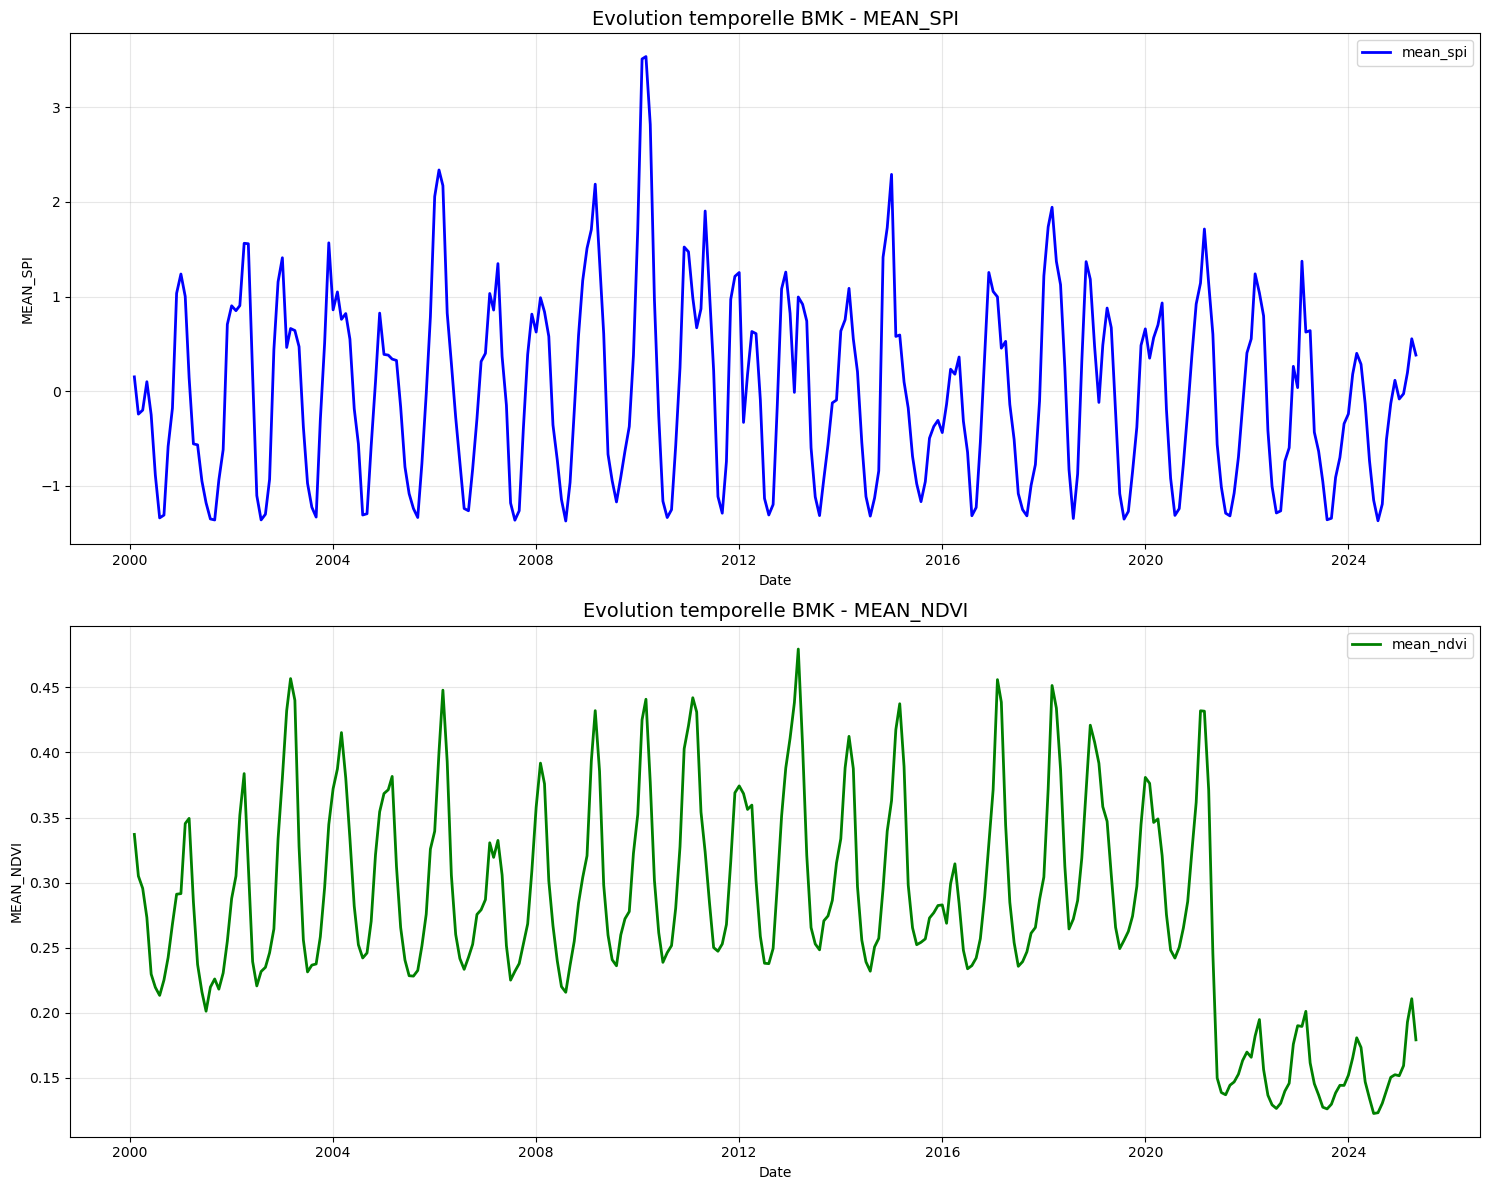

In [32]:
create_time_series_plot(merged_df, ['mean_spi', 'mean_ndvi'], 'Evolution temporelle BMK')

In [33]:

def analyze_seasonality(df, value_col):
    df_copy = df.copy()
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['season'] = df_copy['month'].map({
        12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
        3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
        6: 'Été', 7: 'Été', 8: 'Été',
        9: 'Automne', 10: 'Automne', 11: 'Automne'
    })
    
    # Analyse mensuelle
    monthly_stats = df_copy.groupby('month')[value_col].agg(['mean', 'std', 'min', 'max'])
    
    # Analyse saisonnière
    seasonal_stats = df_copy.groupby('season')[value_col].agg(['mean', 'std', 'min', 'max'])
    
    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Boxplot mensuel
    df_copy.boxplot(column=value_col, by='month', ax=axes[0,0])
    axes[0,0].set_title(f'Distribution mensuelle de {value_col.upper()}')
    axes[0,0].set_xlabel('Mois')
    
    # Boxplot saisonnier
    df_copy.boxplot(column=value_col, by='season', ax=axes[0,1])
    axes[0,1].set_title(f'Distribution saisonnière de {value_col.upper()}')
    
    # Moyennes mensuelles
    monthly_stats['mean'].plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title(f'Moyennes mensuelles de {value_col.upper()}')
    axes[1,0].set_xlabel('Mois')
    
    # Moyennes saisonnières
    seasonal_stats['mean'].plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title(f'Moyennes saisonnières de {value_col.upper()}')
    
    plt.suptitle('')
    plt.tight_layout()
    plt.show()
    
    return monthly_stats, seasonal_stats

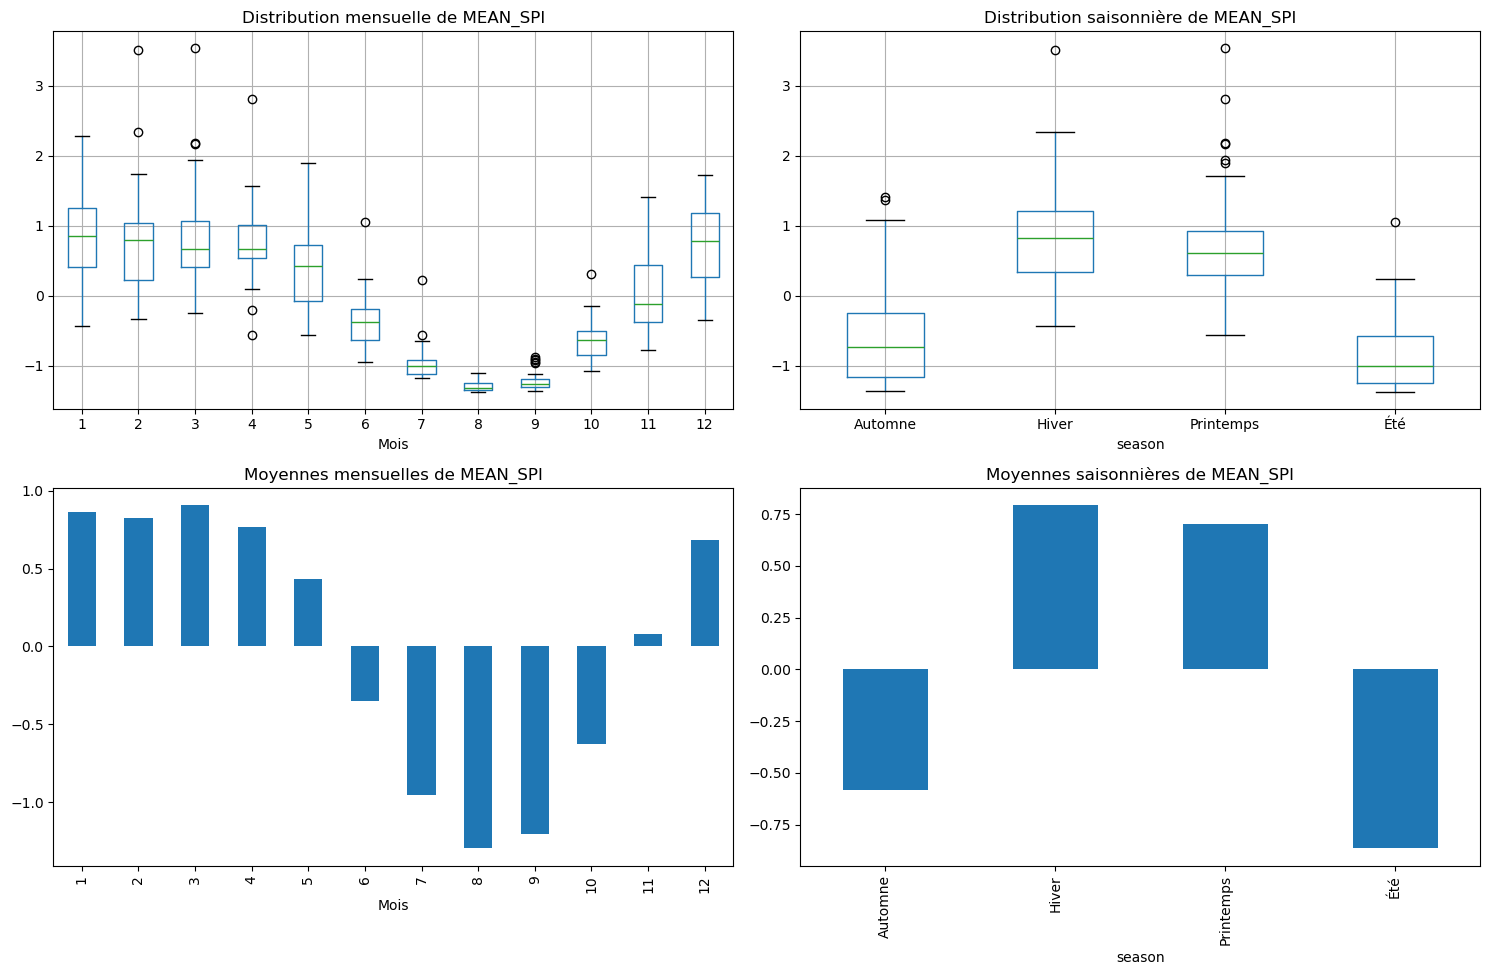

In [34]:
monthly_spi, seasonal_spi = analyze_seasonality(merged_df, 'mean_spi')

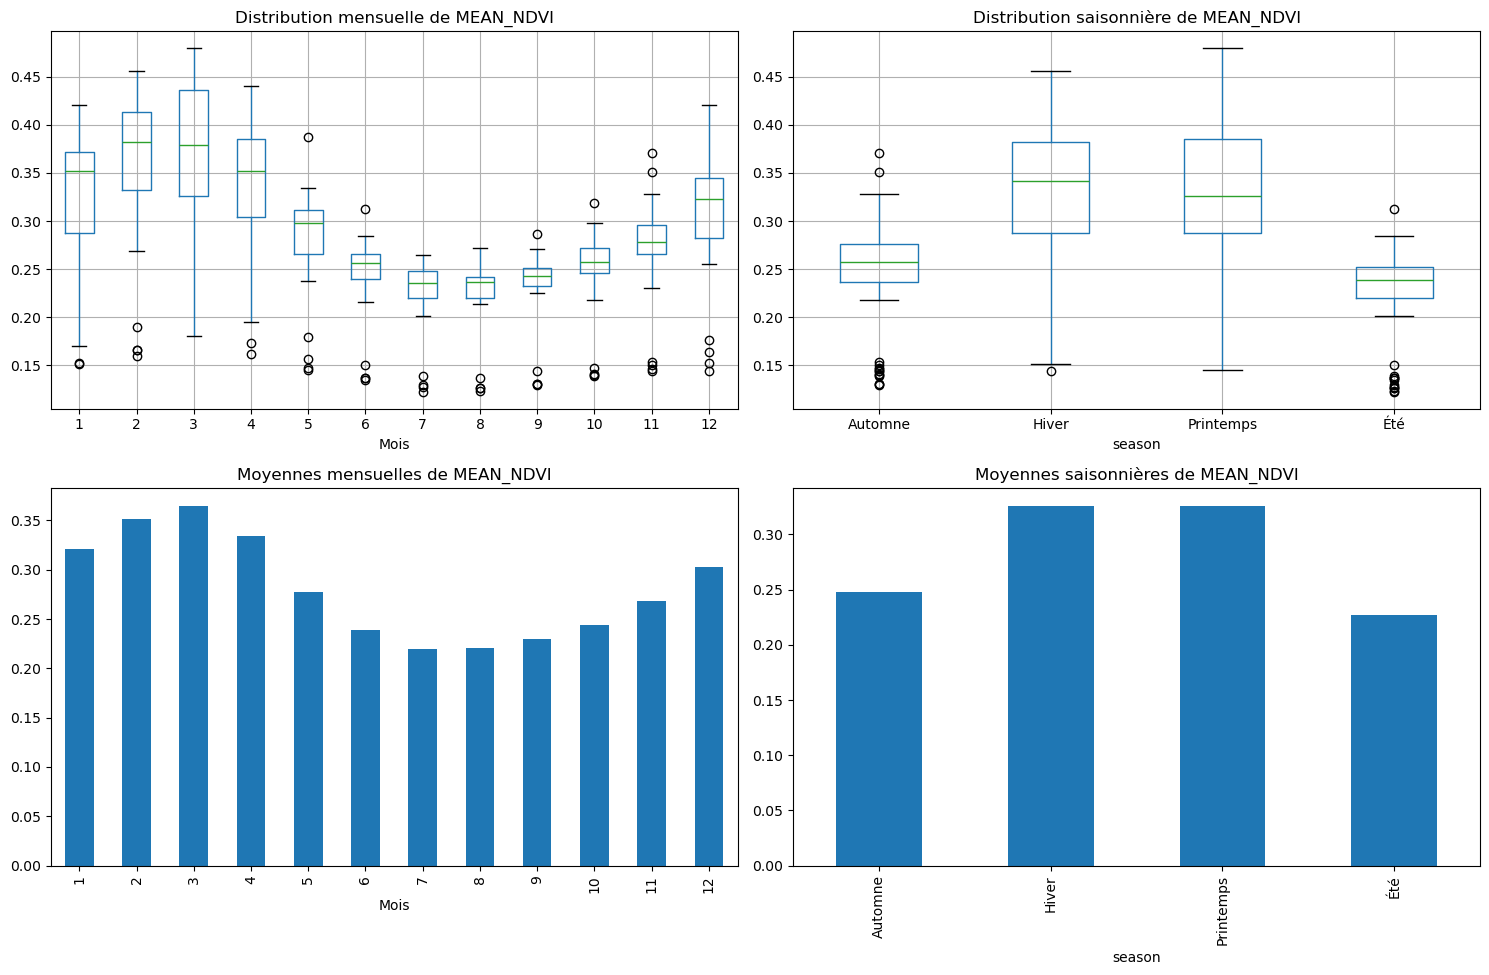

In [35]:
monthly_ndvi, seasonal_ndvi = analyze_seasonality(merged_df, 'mean_ndvi')

In [ ]:
def Correlation_analysis(df):
    correlation= df[['mean_spi', 'mean_ndvi']].corr()
    # test de significativite 

    corr_coef, p_value = pearsonr(df['mean_ndvi'].dropna(), df['mean_spi'].dropna())
    # vis 
    fig , axes = plt.subplots(1, 2, figsize=(15, 6))

    # mat  de correlation 
    sns.heatmap(correlation, annot=True, cmap='RdBu_r',center=0, ax= axes[0])
    axes[0].set_title('Matrrice de correlation NDVI-SPI')
     # Scatter plot
    axes[1].scatter(df['mean_spi'], df['mean_ndvi'], alpha=0.6, color='green')
    axes[1].set_xlabel('SPI')
    axes[1].set_ylabel('NDVI')
    axes[1].set_title(f'Relation NDVI-SPI (r={corr_coef:.3f}, p={p_value:.3f})')
    
    # Ligne de régression
    z = np.polyfit(df['mean_spi'].dropna(), df['mean_ndvi'].dropna(), 1)
    p = np.poly1d(z)
    axes[1].plot(df['mean_spi'], p(df['mean_spi']), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    return corr_coef, p_value


Analyse de la correlation entre SPI et NDVI:


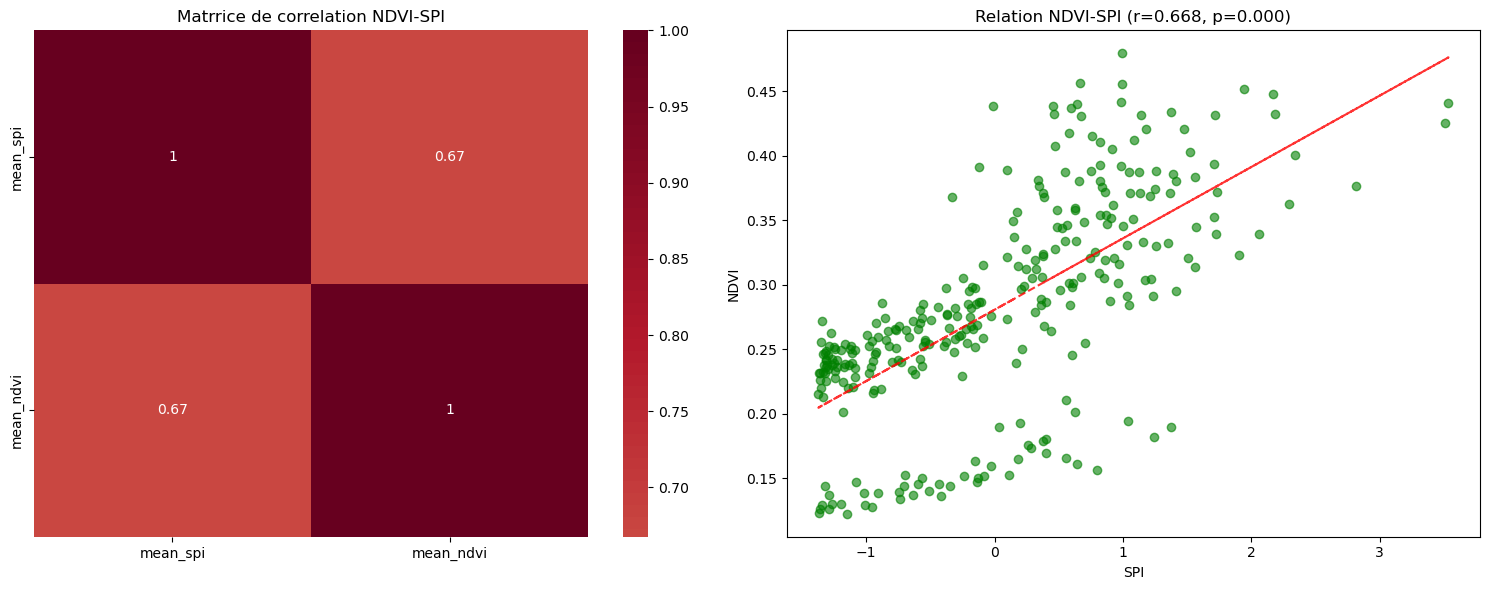

In [37]:
print('Analyse de la correlation entre SPI et NDVI:')
corr_coef, p_value = Correlation_analysis(merged_df)

**le SPI est un bon indicateur pour anticiper la reponse d ela vegentation (NDVI) et donc la sechresse, mais il n'explique pas tout à lui seul (temprerature , sols ..)**

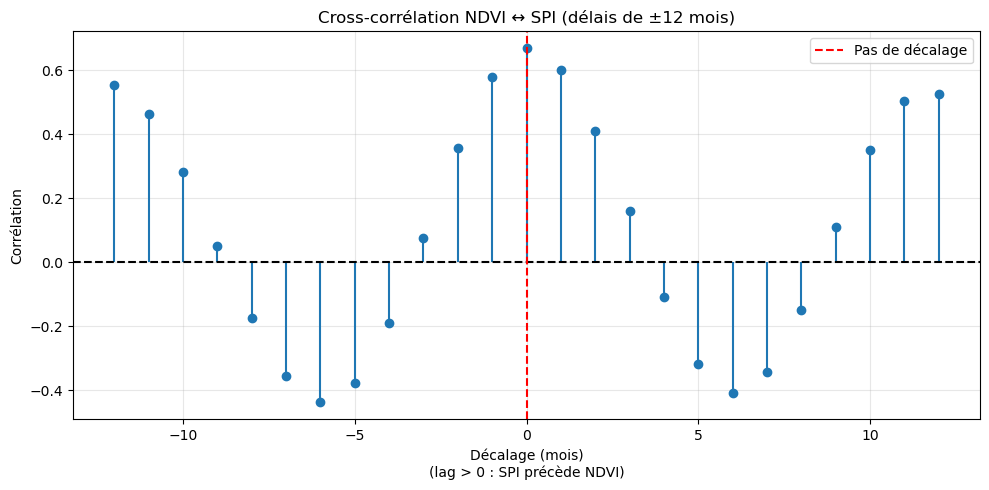

In [ ]:
from scipy.signal import correlate

def compute_cross_correlation(df, max_lag=12, normalize=True):
    spi = df['mean_spi'].dropna().values
    ndvi = df['mean_ndvi'].dropna().values

    # Alignement sur la même longueur
    min_len = min(len(spi), len(ndvi))
    spi = spi[-min_len:]
    ndvi = ndvi[-min_len:]

    if normalize:
        spi = (spi - np.mean(spi)) / np.std(spi)
        ndvi = (ndvi - np.mean(ndvi)) / np.std(ndvi)

    # Corrélation croisée
    corr = correlate(ndvi, spi, mode='full') / len(spi)
    lags = np.arange(-len(spi) + 1, len(spi))
    
    mask = (lags >= -max_lag) & (lags <= max_lag)
    corr = corr[mask]
    lags = lags[mask]
    
    return lags, corr

def plot_cross_correlation(df, max_lag=12):
    lags, corr = compute_cross_correlation(df, max_lag=max_lag)

    plt.figure(figsize=(10, 5))
    plt.stem(lags, corr, basefmt=" ")
    plt.axhline(0, color='black', linestyle='--')
    plt.axvline(0, color='red', linestyle='--', label="Pas de décalage")
    plt.title(f"Cross-corrélation NDVI ↔ SPI (délais de ±{max_lag} mois)")
    plt.xlabel("Décalage (mois)\n(lag > 0 : SPI précède NDVI)")
    plt.ylabel("Corrélation")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_cross_correlation(merged_df, max_lag=12)


## C. Detection et classification de la sechresse 

### Classification de la sechresse 

In [39]:
def classify_drought(spi_series, ndvi_series):
    result = []
    for spi, ndvi in zip(spi_series, ndvi_series):
        if pd.isna(spi) or pd.isna(ndvi):
            result.append(np.nan)
        elif spi < -2 and ndvi < 0.2:
            result.append('Sechresse extrême')
        elif spi < -1.5:
            result.append('Sechresse sévère')
        elif spi < -1.0:
            result.append('Sechresse moderée')
        elif spi > 0.5:
            result.append('Humide')
        else:
            result.append('Normale')
    return pd.Series(result, index=spi_series.index) 


In [40]:
def detect_drought_events(df, spi_threshold=-1.0, duration_threshold=3):
    df_copy= df.copy()
    df_copy['drought'] = df_copy['mean_spi'] < spi_threshold

    # identifier les periodes continues de sechresse 
    df_copy['drought_group'] = (df_copy['drought'] != df_copy['drought'].shift()).cumsum()

    drought_events = []

    for group_id, group in df_copy.groupby('drought_group'):
        if group['drought'].iloc[0] and len(group) >= duration_threshold:
            drought_events.append({
                'start_date': group['date'].min(),
                'end_date': group['date'].max(),
                'duration_months': len(group),
                'min_spi': group['mean_spi'].min(),
                'avg_spi': group['mean_spi'].mean(),
                'min_ndvi': group['mean_ndvi'].min(),
                'avg_ndvi': group['mean_ndvi'].mean()
            })
    return pd.DataFrame(drought_events)


In [41]:
drought_events =  detect_drought_events(merged_df)
print(drought_events)
print('\n')
print(f'Evenements de sechresse detectés :{len(drought_events)}')

   start_date   end_date  duration_months   min_spi   avg_spi  min_ndvi  \
0  2001-07-01 2001-09-01                3 -1.361173 -1.297216  0.201232   
1  2002-07-01 2002-09-01                3 -1.360748 -1.255109  0.220661   
2  2005-07-01 2005-09-01                3 -1.335073 -1.219619  0.228187   
3  2007-07-01 2007-09-01                3 -1.363397 -1.269894  0.225108   
4  2010-07-01 2010-09-01                3 -1.335720 -1.250165  0.238777   
5  2012-07-01 2012-09-01                3 -1.308340 -1.213380  0.237770   
6  2014-07-01 2014-09-01                3 -1.320354 -1.187483  0.231975   
7  2017-07-01 2017-09-01                3 -1.317790 -1.217765  0.235730   
8  2019-07-01 2019-09-01                3 -1.352203 -1.235802  0.249353   
9  2021-07-01 2021-10-01                4 -1.318096 -1.174757  0.137018   
10 2022-07-01 2022-09-01                3 -1.287201 -1.186617  0.126492   
11 2024-07-01 2024-09-01                3 -1.369624 -1.238638  0.122634   

    avg_ndvi  
0   0.215

In [42]:
if len(drought_events) > 0:
    drought_events.to_csv('drought_events_bmk.csv', index=False)
    print(drought_events.head())

  start_date   end_date  duration_months   min_spi   avg_spi  min_ndvi  \
0 2001-07-01 2001-09-01                3 -1.361173 -1.297216  0.201232   
1 2002-07-01 2002-09-01                3 -1.360748 -1.255109  0.220661   
2 2005-07-01 2005-09-01                3 -1.335073 -1.219619  0.228187   
3 2007-07-01 2007-09-01                3 -1.363397 -1.269894  0.225108   
4 2010-07-01 2010-09-01                3 -1.335720 -1.250165  0.238777   

   avg_ndvi  
0  0.215653  
1  0.229107  
2  0.229731  
3  0.231599  
4  0.245530  


In [43]:
if len(drought_events) >0 :
    fig = px.timeline(drought_events, 
                      x_start='start_date', 
                      x_end='end_date', 
                      y='duration_months', 
                      color='avg_spi',
                      title='Événements de sécheresse détectés (BMK)',
                      labels={'avg_spi': 'SPI moyen'})
    fig.update_layout(xaxis_title='Date', yaxis_title='Durée (mois)')
    fig.show()


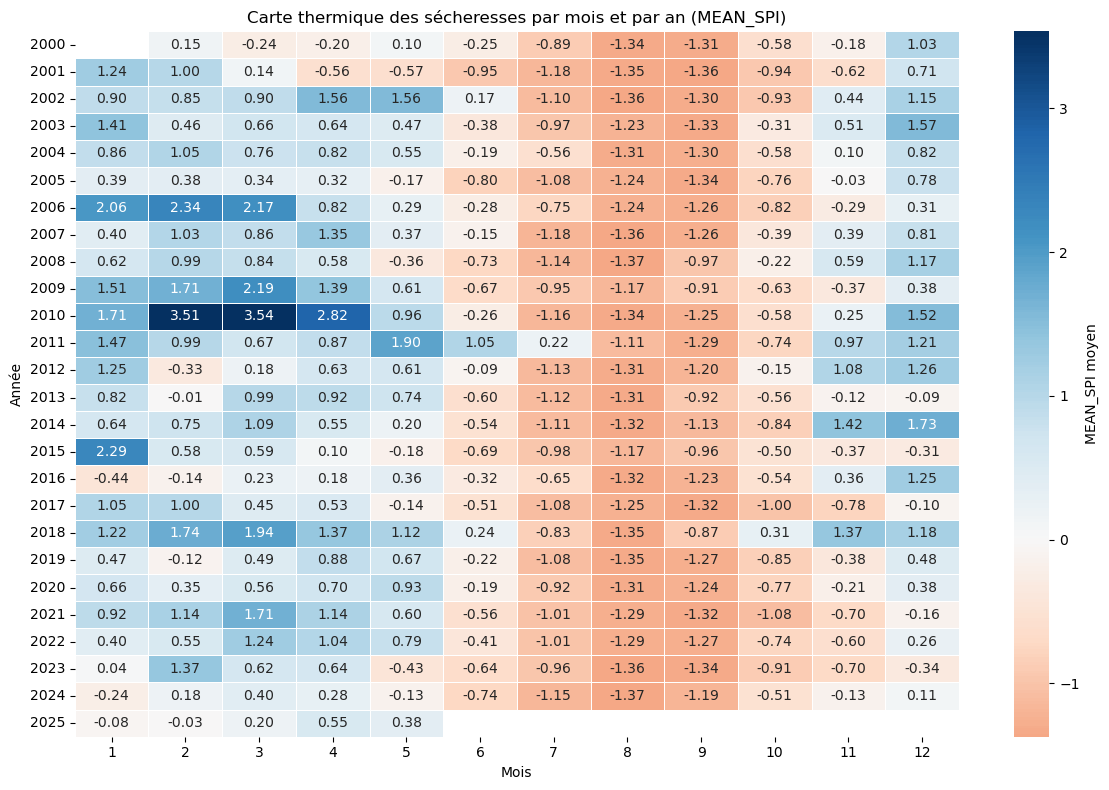

<Figure size 640x480 with 0 Axes>

In [ ]:
def generate_drought_heatmap(df, index_col='mean_spi'):
    df_copy = df.copy()
    df_copy['Year'] = df_copy['date'].dt.year
    df_copy['Month'] = df_copy['date'].dt.month

    heatmap_data = df_copy.pivot_table(
        index='Year', 
        columns='Month', 
        values=index_col, 
        aggfunc='mean'
    )

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data,
        cmap='RdBu',
        center=0,
        linewidths=0.5,
        annot=True,
        fmt=".2f",
        cbar_kws={'label': f'{index_col.upper()} moyen'}
    )
    plt.title(f'Carte thermique des sécheresses par mois et par an ({index_col.upper()})')
    plt.xlabel("Mois")
    plt.ylabel("Année")
    plt.tight_layout()
    plt.show()


generate_drought_heatmap(merged_df, index_col='mean_spi')
plt.savefig('carte_de_sechresse.png', dpi=300, bbox_inches='tight')


## Modelisation predictive

In [45]:
def prepare_features(df, lag_periods=[1, 2, 3, 6, 12]):
    df_features = df.copy()

    df_features['month'] = df_features['date'].dt.month
    df_features['year'] = df_features['date'].dt.year
    df_features['season'] = df_features['month'].map({
        12: 0, 1: 0, 2: 0,  # Hiver
        3: 1, 4: 1, 5: 1,   # Printemps
        6: 2, 7: 2, 8: 2,   # Été
        9: 3, 10: 3, 11: 3  # Automne
    })

    for lag in lag_periods:
        df_features[f'ndvi_lag_{lag}'] = df_features['mean_ndvi'].shift(lag)
        df_features[f'spi_lag_{lag}'] = df_features['mean_spi'].shift(lag)

    # MM
    for window in [3, 6, 12]:
        df_features[f'ndvi_mm_{window}'] = df_features['mean_ndvi'].rolling(window=window).mean()
        df_features[f'spi_mm_{window}'] = df_features['mean_spi'].rolling(window=window).mean()

    # tendance 
    df_features['ndvi_trend'] = df_features['mean_ndvi'].diff()
    df_features['spi_trend'] = df_features['mean_spi'].diff()
    
    return df_features
    

In [ ]:
def train_drought_prediction_model(df):
    df_features = prepare_features(df)
    df_features = df_features.dropna(subset=['mean_spi', 'mean_ndvi'])

    df_features['drought_class'] = classify_drought(df_features['mean_spi'], df_features['mean_ndvi'])

    # encoding the classes 
    drought_encoding = {
        'Humide' : 0, 'Normale': 1, 'Sechresse moderée': 2,
        'Sechresse sévère': 3, 'Sechresse extrême':4
    }
    df_features['drought_encoded']= df_features['drought_class'].map(drought_encoding)

    features_cols = [col for col in df_features.columns if col not in ['date', 'drought_class', 'drought_encoded']]
    df_clean = df_features.dropna()

    if len(df_clean)==0:
        print('pas assez de donnees apres nettoyage')
        return None, None, None
    X = df_clean[features_cols]
    y = df_clean['drought_encoded']

    # division train / test

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if len(y.unique()) > 1 else None)

    # standardisation 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # entrainement du modele 

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # predictions 
    y_pred = model.predict(X_test_scaled)

    # evaluation 
    print(f'Accuracy :{model.score(X_test_scaled, y_test):.2f}')
    print('\nRapport de classification :')
    print(classification_report(y_test, y_pred))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de confusion')
    plt.xlabel('Predictions')
    plt.ylabel('Valeurs reelles')
    plt.show()


    # feature importance
    features_importance = pd.DataFrame({
        'feature': features_cols,
        'importance': model.feature_importances_,
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=features_importance.head(15))
    plt.title('Importance des features - Top 15')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return model, scaler, features_importance

Accuracy :0.98

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.96      1.00      0.98        27
           2       1.00      0.92      0.96        12

    accuracy                           0.98        59
   macro avg       0.99      0.97      0.98        59
weighted avg       0.98      0.98      0.98        59



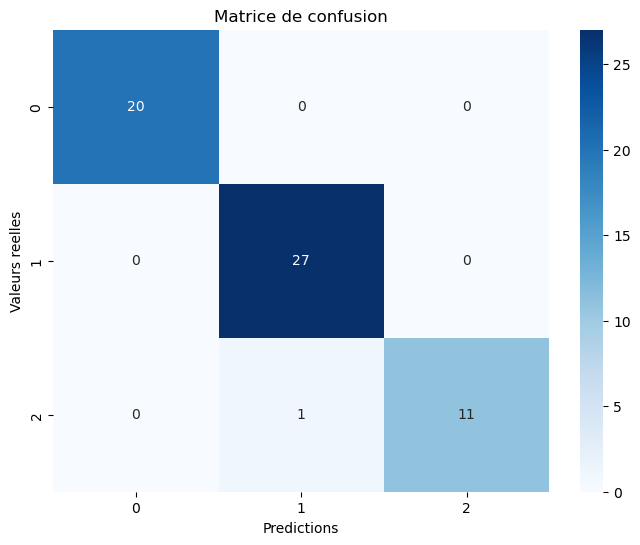

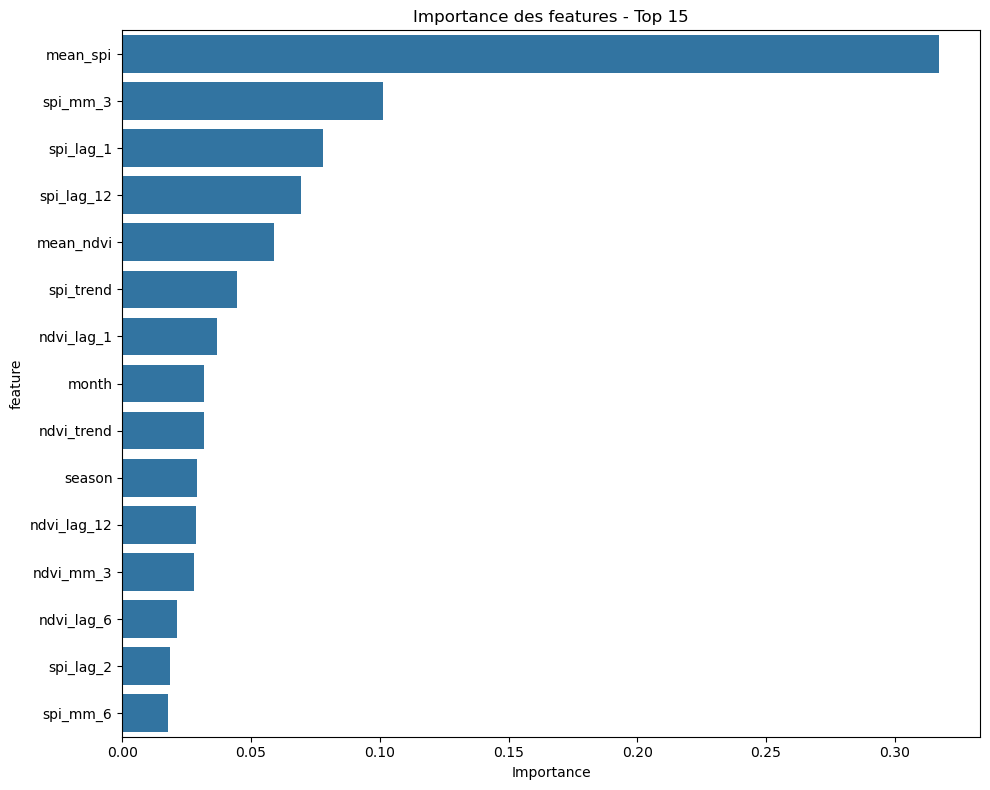

(RandomForestClassifier(random_state=42),
 StandardScaler(),
         feature  importance
 0      mean_spi    0.317195
 16     spi_mm_3    0.101207
 6     spi_lag_1    0.078143
 14   spi_lag_12    0.069426
 1     mean_ndvi    0.058806
 22    spi_trend    0.044660
 5    ndvi_lag_1    0.036979
 2         month    0.031657
 21   ndvi_trend    0.031593
 4        season    0.028913
 13  ndvi_lag_12    0.028745
 15    ndvi_mm_3    0.027926
 11   ndvi_lag_6    0.021247
 8     spi_lag_2    0.018430
 18     spi_mm_6    0.017777
 10    spi_lag_3    0.014261
 12    spi_lag_6    0.012690
 17    ndvi_mm_6    0.012351
 19   ndvi_mm_12    0.011496
 9    ndvi_lag_3    0.010866
 7    ndvi_lag_2    0.010100
 20    spi_mm_12    0.009518
 3          year    0.006014)

In [47]:
train_drought_prediction_model(merged_df)

In [48]:
def train_ndvi_prediction_model(df):
    df_features = prepare_features(df)

    feature_cols = [col for col in df_features.columns if col not in ['date', 'mean_ndvi'] and 'ndvi' not in col]

    df_clean = df_features.dropna()
    
    if len(df_clean) == 0:
        print('pas assez de donnees pour predire NDVI')
        return None, None
    
    X = df_clean[feature_cols]
    y= df_clean['mean_ndvi']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train) 

    y_pred =  model.predict(X_test_scaled)

    # evalutaion 
    mse= mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    print(f'MSE: {mse:.6f}')
    print(f'R²: {r2:.6f}')
    print(f'RMSE: {np.sqrt(mse):.6f}')

    # Vis des perdictions 
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('NDVI observé')
    plt.ylabel('NDVI prédit')
    plt.title(f'Prediction de NDVI (R²={r2:.3f})')
    plt.grid(True, alpha=0.3)
    plt.show()
    return model, scaler

MSE: 0.000556
R²: 0.931448
RMSE: 0.023581


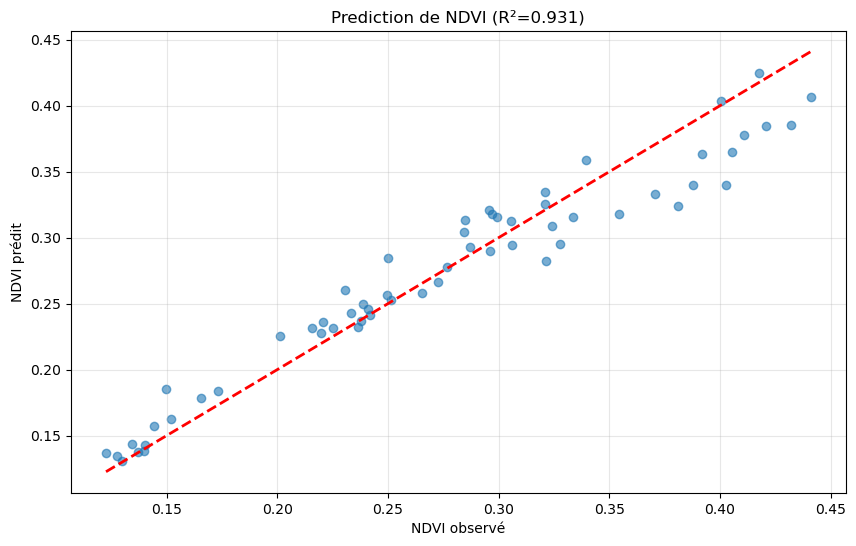

(RandomForestRegressor(random_state=42), StandardScaler())

In [49]:
train_ndvi_prediction_model(merged_df)

MSE: 0.000576
R²: 0.928984
RMSE: 0.024001


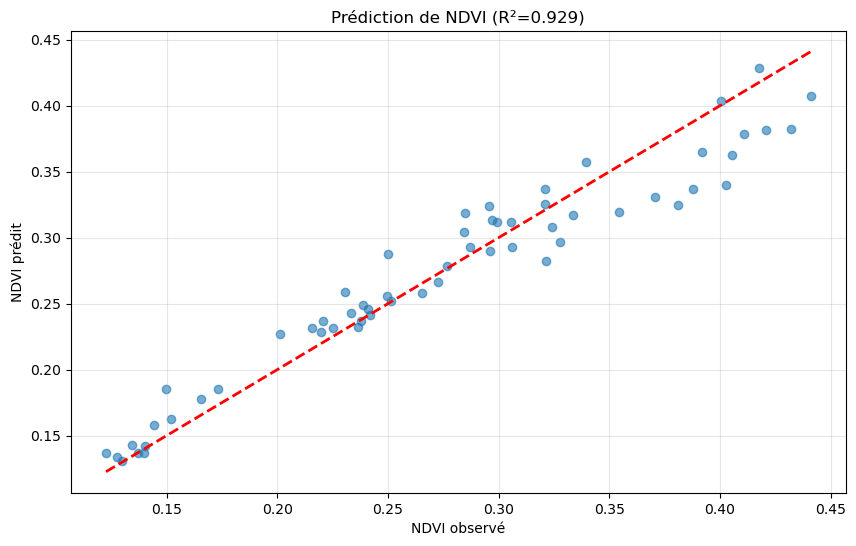

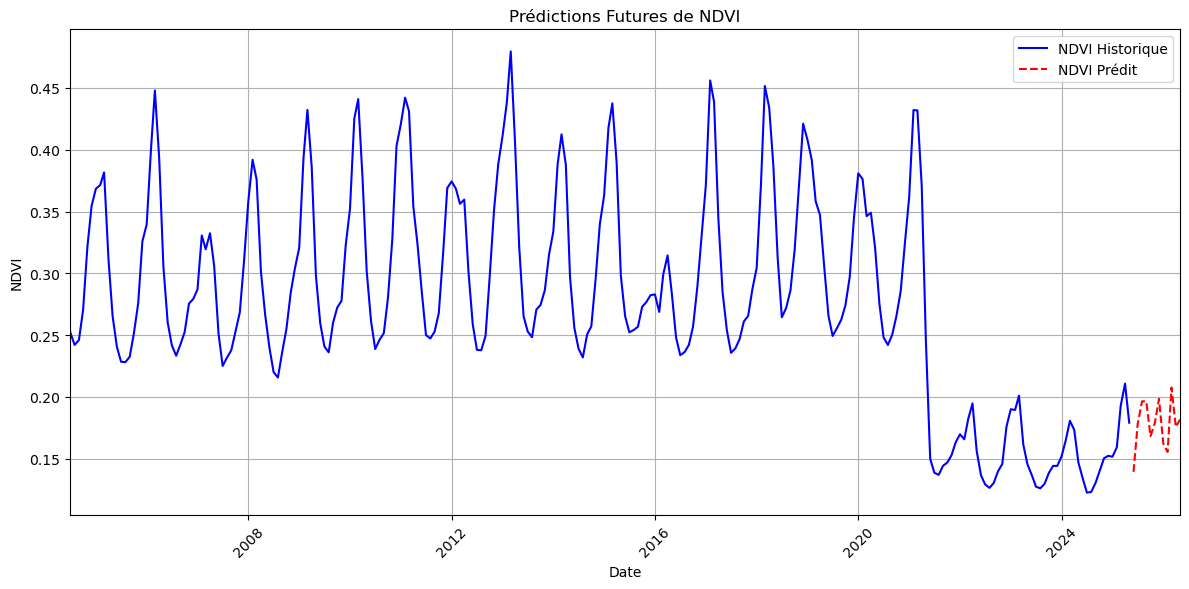

         date  mean_spi  predicted_ndvi
0  2025-06-01 -2.032397        0.139435
1  2025-07-01  0.532114        0.178222
2  2025-08-01  2.245270        0.196472
3  2025-09-01  0.966774        0.196449
4  2025-10-01  0.030564        0.168276
5  2025-11-01  0.320981        0.178846
6  2025-12-01  0.915391        0.198511
7  2026-01-01 -0.928670        0.162267
8  2026-02-01 -0.959004        0.155590
9  2026-03-01  2.489018        0.207662
10 2026-04-01 -0.116089        0.175787
11 2026-05-01  0.028607        0.181704


In [ ]:
def predict_future_ndvi(model, scaler, feature_cols, historical_df, future_periods=12, future_spi_scenario=None):

    last_date = historical_df['date'].max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_periods, freq='MS')
    future_df = pd.DataFrame({'date': future_dates})
    
    if future_spi_scenario is None:
        mean_spi = historical_df['mean_spi'].mean()
        future_df['mean_spi'] = mean_spi
    else:
        if len(future_spi_scenario) != future_periods:
            raise ValueError("La longueur de future_spi_scenario doit correspondre à future_periods.")
        future_df['mean_spi'] = future_spi_scenario
    
    full_df = pd.concat([historical_df, future_df], ignore_index=True)
    full_df['mean_ndvi'] = full_df['mean_ndvi'].fillna(0)  
    full_features = prepare_features(full_df)
    
    future_features = full_features.iloc[-future_periods:]
    X_future = future_features[feature_cols]  
    
    X_future = X_future.fillna(0)
    
    X_future_scaled = scaler.transform(X_future)
    future_ndvi = model.predict(X_future_scaled)
    future_df['predicted_ndvi'] = future_ndvi
    
    # Visualisation des prédictions futures
    plt.figure(figsize=(12, 6))
    plt.plot(historical_df['date'], historical_df['mean_ndvi'], label='NDVI Historique', color='blue')
    plt.plot(future_df['date'], future_df['predicted_ndvi'], label='NDVI Prédit', color='red', linestyle='--')

    min_date = historical_df['date'].max() - pd.DateOffset(months=250)
    plt.xlim(min_date, future_df['date'].max())

    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.title('Prédictions Futures de NDVI')
    plt.legend()
    plt.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    
    return future_df

mean_spi = merged_df['mean_spi'].mean()
std_spi = merged_df['mean_spi'].std()
future_spi_scenario = np.random.normal(mean_spi, std_spi, 12)
model, scaler, feature_cols = train_ndvi_prediction_model(merged_df)
future_predictions = predict_future_ndvi(model, scaler, feature_cols, merged_df, future_periods=12, future_spi_scenario=future_spi_scenario)
print(future_predictions)

### Rapport d’Analyse de la Sécheresse

In [50]:
def generate_drought_report(df, drought_events):
    """Génère un rapport complet sur la sécheresse"""
    print("=" * 60)
    print("RAPPORT D'ANALYSE DE LA SÉCHERESSE")
    print("Région : Béni Mellal-Khénifra")
    print("=" * 60)
    
    # Statistiques générales
    print(f"\n1. PÉRIODE D'ANALYSE:")
    print(f"   - Début: {df['date'].min().strftime('%Y-%m-%d')}")
    print(f"   - Fin: {df['date'].max().strftime('%Y-%m-%d')}")
    print(f"   - Nombre d'observations: {len(df)}")
    
    # Statistiques SPI
    print(f"\n2. STATISTIQUES SPI:")
    print(f"   - Moyenne: {df['mean_spi'].mean():.3f}")
    print(f"   - Écart-type: {df['mean_spi'].std():.3f}")
    print(f"   - Minimum: {df['mean_spi'].min():.3f}")
    print(f"   - Maximum: {df['mean_spi'].max():.3f}")
    
    # Statistiques NDVI
    print(f"\n3. STATISTIQUES NDVI:")
    print(f"   - Moyenne: {df['mean_ndvi'].mean():.3f}")
    print(f"   - Écart-type: {df['mean_ndvi'].std():.3f}")
    print(f"   - Minimum: {df['mean_ndvi'].min():.3f}")
    print(f"   - Maximum: {df['mean_ndvi'].max():.3f}")
    
    # Événements de sécheresse
    print(f"\n4. ÉVÉNEMENTS DE SÉCHERESSE DÉTECTÉS:")
    print(f"   - Nombre total: {len(drought_events)}")
    
    if len(drought_events) > 0:
        print(f"   - Durée moyenne: {drought_events['duration_months'].mean():.1f} mois")
        print(f"   - Durée maximale: {drought_events['duration_months'].max()} mois")
        print(f"   - SPI minimum enregistré: {drought_events['min_spi'].min():.3f}")
        
        print("\n   Événements les plus sévères:")
        severe_events = drought_events.nsmallest(3, 'min_spi')
        for _, event in severe_events.iterrows():
            print(f"     • {event['start_date'].strftime('%Y-%m')} - "
                  f"{event['end_date'].strftime('%Y-%m')} "
                  f"(SPI min: {event['min_spi']:.3f})")
    
    # Classification des conditions
    drought_classes = classify_drought(df['mean_spi'], df['mean_ndvi'])
    class_counts = pd.Series(drought_classes).value_counts()
    
    print(f"\n5. RÉPARTITION DES CONDITIONS:")
    for condition, count in class_counts.items():
        percentage = (count / len(drought_classes)) * 100
        print(f"   - {condition}: {count} mois ({percentage:.1f}%)")
    
    # Corrélation
    corr_coef, p_value = pearsonr(df['mean_ndvi'].dropna(), df['mean_spi'].dropna())
    print(f"\n6. CORRÉLATION NDVI-SPI:")
    print(f"   - Coefficient de corrélation: {corr_coef:.3f}")
    print(f"   - P-value: {p_value:.6f}")
    print(f"   - Significativité: {'Significative' if p_value < 0.05 else 'Non significative'}")
    
    print("\n" + "=" * 60)
    print("FIN DU RAPPORT")
    print("=" * 60)

In [51]:
generate_drought_report(merged_df, drought_events)

RAPPORT D'ANALYSE DE LA SÉCHERESSE
Région : Béni Mellal-Khénifra

1. PÉRIODE D'ANALYSE:
   - Début: 2000-02-01
   - Fin: 2025-05-01
   - Nombre d'observations: 304

2. STATISTIQUES SPI:
   - Moyenne: 0.021
   - Écart-type: 0.989
   - Minimum: -1.372
   - Maximum: 3.536

3. STATISTIQUES NDVI:
   - Moyenne: 0.282
   - Écart-type: 0.082
   - Minimum: 0.123
   - Maximum: 0.479

4. ÉVÉNEMENTS DE SÉCHERESSE DÉTECTÉS:
   - Nombre total: 12
   - Durée moyenne: 3.1 mois
   - Durée maximale: 4 mois
   - SPI minimum enregistré: -1.370

   Événements les plus sévères:
     • 2024-07 - 2024-09 (SPI min: -1.370)
     • 2007-07 - 2007-09 (SPI min: -1.363)
     • 2001-07 - 2001-09 (SPI min: -1.361)

5. RÉPARTITION DES CONDITIONS:
   - Normale: 141 mois (46.4%)
   - Humide: 103 mois (33.9%)
   - Sechresse moderée: 60 mois (19.7%)

6. CORRÉLATION NDVI-SPI:
   - Coefficient de corrélation: 0.668
   - P-value: 0.000000
   - Significativité: Significative

FIN DU RAPPORT


In [ ]:
def create_interactive_dashboard(df, drought_events):
    
    df_copy = df.copy()
    df_copy['drought_class'] = classify_drought(df_copy['mean_spi'], df_copy['mean_ndvi'])
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['month'] = df_copy['date'].dt.month
    
    # Création des sous-graphiques
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=('Évolution temporelle SPI', 'Évolution temporelle NDVI',
                       'Relation SPI-NDVI', 'Distribution des classes de sécheresse',
                       'Tendances annuelles', 'Patterns saisonniers'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # Évolution temporelle SPI
    fig.add_trace(
        go.Scatter(x=df_copy['date'], y=df_copy['mean_spi'],
                  mode='lines', name='SPI', line=dict(color='blue')),
        row=1, col=1
    )
    
    # Ajout des seuils de sécheresse
    fig.add_hline(y=-1.0, line_dash="dash", line_color="orange", 
                  annotation_text="Sécheresse modérée", row=1, col=1)
    fig.add_hline(y=-1.5, line_dash="dash", line_color="red", 
                  annotation_text="Sécheresse sévère", row=1, col=1)
    
    # Évolution temporelle NDVI
    fig.add_trace(
        go.Scatter(x=df_copy['date'], y=df_copy['mean_ndvi'],
                  mode='lines', name='NDVI', line=dict(color='green')),
        row=1, col=2
    )
    
    # Relation SPI-NDVI
    fig.add_trace(
        go.Scatter(x=df_copy['mean_spi'], y=df_copy['mean_ndvi'],
                  mode='markers', name='SPI-NDVI', 
                  marker=dict(color=df_copy['year'], colorscale='viridis',
                             showscale=True, colorbar=dict(title="Année"))),
        row=2, col=1
    )
    
    # Distribution des classes de sécheresse
    class_counts = df_copy['drought_class'].value_counts()
    fig.add_trace(
        go.Bar(x=class_counts.index, y=class_counts.values,
               name='Classes', marker_color='lightblue'),
        row=2, col=2
    )
    
    # Tendances annuelles
    annual_stats = df_copy.groupby('year').agg({
        'mean_spi': 'mean',
        'mean_ndvi': 'mean'
    }).reset_index()
    
    fig.add_trace(
        go.Scatter(x=annual_stats['year'], y=annual_stats['mean_spi'],
                  mode='lines+markers', name='SPI annuel', line=dict(color='blue')),
        row=3, col=1
    )
    
    # Patterns saisonniers
    seasonal_stats = df_copy.groupby('month').agg({
        'mean_spi': 'mean',
        'mean_ndvi': 'mean'
    }).reset_index()
    
    fig.add_trace(
        go.Scatter(x=seasonal_stats['month'], y=seasonal_stats['mean_spi'],
                  mode='lines+markers', name='SPI saisonnier', line=dict(color='blue')),
        row=3, col=2
    )
    
    fig.update_layout(
        height=1200,
        title_text="Tableau de bord - Analyse de la sécheresse BMK",
        showlegend=False
    )
    
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_xaxes(title_text="Date", row=1, col=2)
    fig.update_xaxes(title_text="SPI", row=2, col=1)
    fig.update_xaxes(title_text="Classes", row=2, col=2)
    fig.update_xaxes(title_text="Année", row=3, col=1)
    fig.update_xaxes(title_text="Mois", row=3, col=2)
    
    fig.update_yaxes(title_text="SPI", row=1, col=1)
    fig.update_yaxes(title_text="NDVI", row=1, col=2)
    fig.update_yaxes(title_text="NDVI", row=2, col=1)
    fig.update_yaxes(title_text="Fréquence", row=2, col=2)
    fig.update_yaxes(title_text="SPI", row=3, col=1)
    fig.update_yaxes(title_text="SPI", row=3, col=2)
    
    fig.show()
    
    return fig


In [53]:
create_interactive_dashboard(merged_df, drought_events)